In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, subprocess
from natsort import natsorted
import pickle

REPO_PATH = subprocess.check_output(['git', 'rev-parse', '--show-toplevel']).decode('utf-8').strip()
plt.style.use(f'{REPO_PATH}/misc/edwin.mplstyle')

In [2]:
from retrieveVariables import retrieveVariables

In [3]:
fields = ["DOC","NH4","NO3","O2","phi"]
isHot  = True

if (isHot):
    ## With hot-start
    RANS = retrieveVariables("/home/edsaa/nuModel/tempBioreactions/2.0NonZeroRANS/2.0NonZeroInitCondition/",fields)
    LES  = retrieveVariables("/home/edsaa/nuModel/tempBioreactions/2.1LES/2.1NonZeroLESRun/",fields)
else:
    ## Without hot-start
    RANS = retrieveVariables("/home/edsaa/nuModel/tempBioreactions/2.3ZeroStartRANS/2.3ZeroRANS",fields)
    LES  = retrieveVariables("/home/edsaa/nuModel/tempBioreactions/2.2ZeroLES/2.2ZeroLES",fields)

In [4]:
## Elliot-Brooks phi
hydCond = 1.3E-3
head_m  = 2.39E-4
bed_wavelenght = 0.15
depth_bed = 0.20
channel_width = 0.29
porosity = 0.33
Axy = bed_wavelenght*channel_width

qBar = (2*hydCond * head_m / bed_wavelenght) * np.tanh(2*np.pi*depth_bed/bed_wavelenght)
qBar *= Axy
print("qBar = {:.2E} m3/s".format(qBar))

qBar = 1.80E-07 m3/s


In [5]:
## Negative phi is flux INTO the bed (influx)

for df in [RANS,LES]:
    df['Time (d)'] = df['Time (s)']/86400
    df['sumPhiIn (m3/s)']  = [ np.sum(np.minimum(p,0)) for p in df['phi'] ]
    df['sumPhiOut (m3/s)'] = [ np.sum(np.maximum(p,0)) for p in df['phi'] ]
    df['sumPhiNet (m3/s)'] = [ np.sum(p) for p in df['phi'] ]
    
    for field in fields: 
        df[f'massIn {field} (kg/s/m2)']  = [ np.sum(np.multiply(np.minimum(p,0),c))/Axy for p,c in zip(df['phi'],df[field]) ]
        df[f'massOut {field} (kg/s/m2)'] = [ np.sum(np.multiply(np.maximum(p,0),c))/Axy for p,c in zip(df['phi'],df[field]) ]
        df[f'massNet {field} (kg/s/m2)'] = [ np.sum(np.multiply(p,c))/Axy for p,c in zip(df['phi'],df[field]) ]

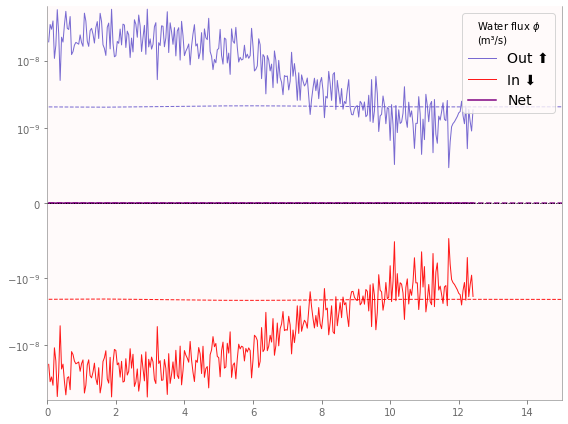

In [6]:
fig,ax = plt.subplots(sharex=True,figsize=[8,6])

df = RANS
ax.plot(df['Time (d)'],df[f'sumPhiOut (m3/s)'],
    c='slateblue',alpha=0.9,lw=1,ls='dashed')
ax.plot(df['Time (d)'],df[f'sumPhiIn (m3/s)'],
    c='red',alpha=0.9,lw=1,ls='dashed')
ax.plot(df['Time (d)'],df[f'sumPhiNet (m3/s)'],
    c='purple',alpha=1,lw=1.5,ls='dashed')

df = LES
ax.plot(df['Time (d)'],df[f'sumPhiOut (m3/s)'],label='Out ⬆️',
    c='slateblue',alpha=0.9,lw=1)
ax.plot(df['Time (d)'],df[f'sumPhiIn (m3/s)'],label='In ⬇️',
    c='red',alpha=0.9,lw=1)
ax.plot(df['Time (d)'],df[f'sumPhiNet (m3/s)'],label='Net',
    c='purple',alpha=1,lw=1.5)


ax.axhline(y=0,ls=':',lw=1,c='k')
#ax.legend(loc='center left',bbox_to_anchor=(1.0,0.5),title="Water flux $\phi$" + "\n(m³/s)")
ax.legend(loc='upper right',bbox_to_anchor=(1.0,1.0),title="Water flux $\phi$" + "\n(m³/s)")

ax.set(xlim=[0,15.])
ax.set_yscale('symlog', linthresh=0.1E-8)

fig.tight_layout()

fileForPNG = f"RetrieveFluxes/{isHot=}_WaterFlux.png"
plt.savefig(fileForPNG)
os.system(f"xclip -se c -t image/png -i {fileForPNG}")
plt.show()

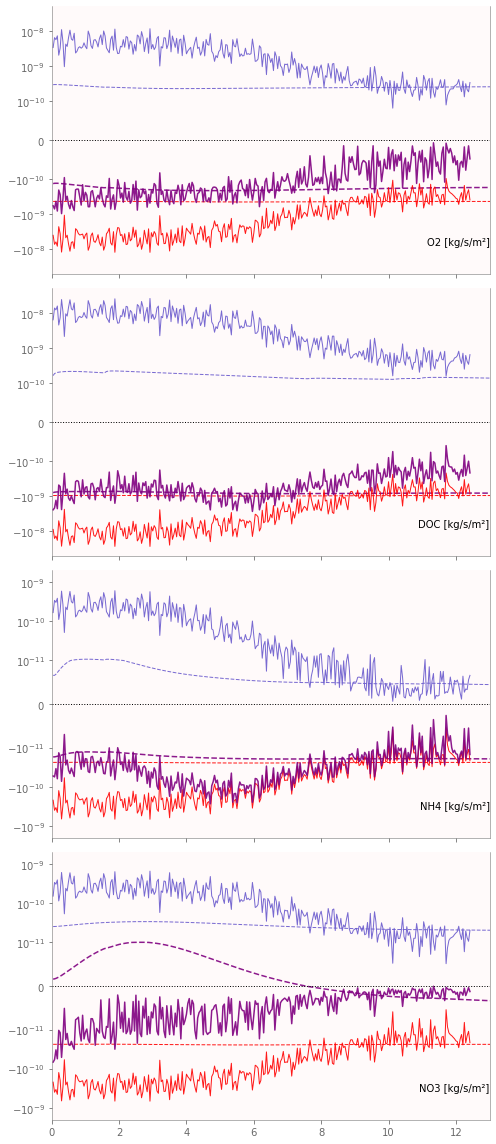

In [9]:
fields = ["O2","DOC","NH4","NO3"]
fig,axs = plt.subplots(len(fields),1,sharex=True,figsize=[7,16])

df = RANS
for ax,field in zip(axs,fields):
    ax.plot(df['Time (d)'],df[f'massIn {field} (kg/s/m2)'],
        c='red',alpha=0.9,lw=1,ls='dashed')
    ax.plot(df['Time (d)'],df[f'massOut {field} (kg/s/m2)'],
        c='slateblue',alpha=0.9,lw=1,ls='dashed')
    ax.plot(df['Time (d)'],df[f'massNet {field} (kg/s/m2)'],
        c='purple',alpha=0.9,lw=1.5,ls='dashed')
    #ax.legend(loc='center left',bbox_to_anchor=(1.0,0.5),title=field+" (kg/s/m2)")
    ax.annotate(f"{field} [kg/s/m²]",
                xy=(1, 0.1), xycoords='axes fraction',
                xytext=(1, 0.1), textcoords='axes fraction',
                horizontalalignment='right',
                verticalalignment='bottom')

df = LES
for ax,field in zip(axs,fields):
    ax.plot(df['Time (d)'],df[f'massIn {field} (kg/s/m2)'],
        c='red',alpha=0.9,lw=1)
    ax.plot(df['Time (d)'],df[f'massOut {field} (kg/s/m2)'],
        c='slateblue',alpha=0.9,lw=1)
    ax.plot(df['Time (d)'],df[f'massNet {field} (kg/s/m2)'],
        c='purple',alpha=0.9,lw=1.5)
    ax.axhline(y=0,ls=':',lw=1,c='k')

for ax in axs[:2]:
    ax.set(xlim=[0,13],ylim=[-5.0E-8,5.0E-8])
    ax.set_yscale('symlog', linthresh=1E-10)

for ax in axs[2:]:
    ax.set(xlim=[0,13],ylim=[-2.0E-9,2.0E-9])
    ax.set_yscale('symlog', linthresh=0.1E-10)

fig.tight_layout()

fileForPNG = f"RetrieveFluxes/{isHot=}_ChemsFlux.png"
plt.savefig(fileForPNG)
os.system(f"xclip -se c -t image/png -i {fileForPNG}")
plt.show()


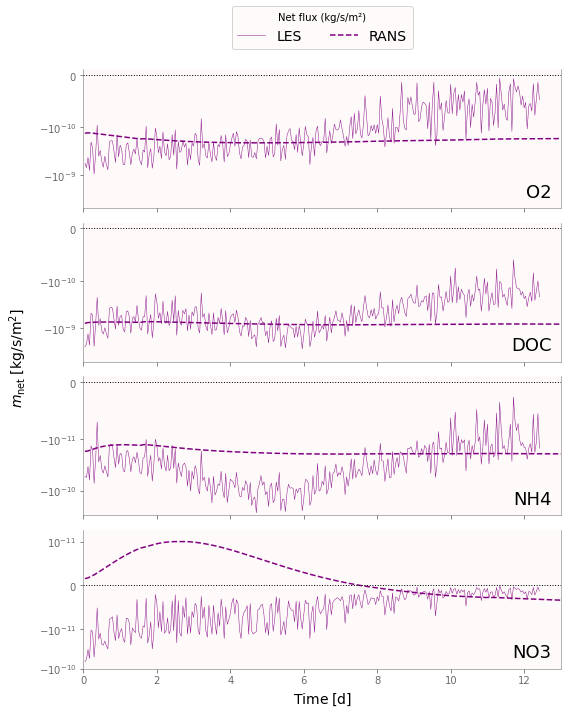

In [8]:
fig,axs = plt.subplots(len(fields),1,sharex=True,figsize=[8,10])

for ax,field in zip(axs,fields):
    ax.plot(LES['Time (d)'],LES[f'massNet {field} (kg/s/m2)'],label='LES',
            c='purple',alpha=0.9,lw=0.5)
    ax.plot(RANS['Time (d)'],RANS[f'massNet {field} (kg/s/m2)'],label='RANS',
            c='purple',lw=1.5,ls='dashed')
    ax.axhline(y=0,ls=':',lw=1,c='k')
    ax.annotate(f"{field}", fontsize=18,
                xy=(0.98, 0.05), xycoords='axes fraction',
                xytext=(0.98, 0.05), textcoords='axes fraction',
                horizontalalignment='right',
                verticalalignment='bottom')

ax.set(xlabel=r"$\mathsf{Time \; [d]}$",xlim=(0,13))
fig.supylabel(r"$m_\mathsf{net} \; \mathsf{[kg/s/m^2]}$",fontsize=14)

axs[0].legend(loc='lower center',bbox_to_anchor=(0.5,1.1),title="Net flux (kg/s/m²)",ncol=2)

axs[0].set_yscale('symlog', linthresh=1.0E-10)
axs[0].set_ylim([-5.0E-9,1.0E-11])

axs[1].set_yscale('symlog', linthresh=1.0E-10)
axs[1].set_ylim([-5.0E-9,1.0E-11])

axs[2].set_yscale('symlog', linthresh=1.0E-11)
axs[2].set_ylim([-3.0E-10,1.0E-12])

axs[3].set_yscale('symlog', linthresh=1.0E-11)
axs[3].set_ylim([-1.0E-10,2.0E-11])

fig.tight_layout()

fileForPNG = f"RetrieveFluxes/{isHot=}_ChemsNet.png"
plt.savefig(fileForPNG)
os.system(f"xclip -se c -t image/png -i {fileForPNG}")
plt.show()